# **Library Book Recommendation System**
---
Authors: [Monicah Iwagit](https://github.com/Okodoimonicah), [Bradley Azegele](https://github.com/Azegele), [Emmanuel Kipkorir](), [Belinda Nyamai](), [Femi Kamau](https://github.com/ctrl-Karugu), and [Dennis Kimiri]()

## 1. Business Understanding

### 1.1 Problem Statement
>The tremendous growth and usage of information has led to information overloading where users find it difficult to locate the right information at a specified time. Although there are previous studies conducted on library recommender systems, the datasets used were small compared to the dataset we intend to use hence minimal area coverage. Recommending the right library books is a challenge due to the variety of genres available and the huge collection of books provided. A user finds it difficult to select the most appropriate book that will suit their academic needs, this process consumes a lot of time that the user would have used to sharpen on their desired skills. Additionally, many books in the library are rarely utilized which results in a waste of library resources. Having a personalized recommendation system seeks to predict the preference based on the user’s interest, behavior and information. The application of recommender systems in a library set up solves the problem of difficulty in choosing books and improves utilization rate of library resources. 

## 2. Data Understanding
> The goal of the Data Understanding phase is to provide a solid foundation for the subsequent steps, including data preparation, exploratory data analysis, model development, and evaluation.

#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import random
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Data Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### 2.1 Collect Initial Data
> The goal of this section is to acquire the necessary data and load it into the notebook.

> The data used in this project was sourced from 2 different sources:
>   1. The first was source was from Cai-Nicolas Ziegler in a 4-week crawl (August-September [2004]) in the University of Freiburg, Germany. This can be found [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The data obtained are 3 datasets with information on [users](./data/BX-Users.csv), [ratings](./data/BX-Book-Ratings.csv) and [books](./data/BX-Books.csv) from a library.
>
>   2. The second set of data was sourced from the [Google Books API](https://developers.google.com/books). This data was obtained by using ISBNs in the books dataset from the first source. The script used to extract the data can be found [here](./make_dataset.py). This data was then stored in csv format and can be found [here](./data/books.csv).

#### Load Data

In [2]:
# (Source 1)
ratings = pd.read_csv("data/BX-Book-Ratings.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books = pd.read_csv("data/BX-Books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
users = pd.read_csv("data/BX-Users.csv", sep=";", error_bad_lines=False, encoding="latin-1")

# (Source 2)
books_extra = pd.read_csv("data/api-books.csv", dtype={"join_isbn_10": str})

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### 2.2 Describe Data
> The goal of this section is to examine the data and document its surface properties.

In [3]:
# Define class to describe the data 
class DescribeData():
    """This class is used to describe the data in a DataFrame."""
    
    def __init__(self, df) -> None:
        
        # Get the DataFrame
        self.df = df
        
        # Get the datatypes of the columns in the DataFrame
        self.datatypes = df.dtypes
         
        # Get the shape of the DataFrame
        self.shape = f"The shape of the DataFrame is {df.shape}\n\nRecords: {df.shape[0]}\nColumns: {df.shape[1]}"
        
        # Get the number of missing values in each column
        self.missing = f"There are a total of {df.isnull().sum().values.sum()} missing values in the DataFrame.\n\n{df.isnull().sum()}"
        
        # Get the number of duplicate rows
        self.duplicates = f"There are {df.duplicated().sum()} duplicated records in the DataFrame."

#### 2.2.1 `ratings`

In [4]:
# Create an instance of the 'DescribeData' class for the 'ratings' DataFrame
rt = DescribeData(ratings)

In [5]:
# Preview the 'ratings' DataFrame
rt.df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
# Inspect the information about the DataFrame
rt.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
# Inspect the shape of the DataFrame
print(rt.shape)

The shape of the DataFrame is (1149780, 3)

Records: 1149780
Columns: 3


In [8]:
# Inspect the datatypes of the columns in the DataFrame
print(rt.datatypes)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [9]:
# Inspect the summary statistics of the DataFrame
rt.df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [10]:
# Inspect the number of missing values in each column
print(rt.missing)

There are a total of 0 missing values in the DataFrame.

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [11]:
# Inspect the duplicates in the DataFrame
print(rt.duplicates)

There are 0 duplicated records in the DataFrame.


[**Ratings Dataset**](./data/BX-Book-Ratings.csv)

>* Spans **3** columns and **1,149,780** rows.

>* Contains **2** unique datatypes: 
>    * **int64**
>    * **object**

>* Has no missing values

>* Has no duplicates

#### 2.2.2 `books` 

In [12]:
# Instantiate the 'DescribeData' class for the 'books' DataFrame
bk = DescribeData(books)

In [13]:
# Preview the 'books' DataFrame
bk.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [14]:
# Inspect the information about the DataFrame
bk.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [15]:
# Inspect the shape of the DataFrame
print(bk.shape)

The shape of the DataFrame is (271360, 8)

Records: 271360
Columns: 8


In [16]:
# Inspect the datatypes of the columns in the DataFrame
print(bk.datatypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [17]:
# Inspect the missing values in the DataFrame
print(bk.missing)

There are a total of 6 missing values in the DataFrame.

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [18]:
# Inspect the duplicates in the DataFrame
print(bk.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books Dataset**](./data/BX-Books.csv)

>* Spans **8** columns and **271,359** rows.

>* Contains 1 unique datatype: 
>   * **object**

>* Has **6** missing values:
>   * Book-Author: **1** 
>   * Publisher: **2**
>   * Image-URL-L: **3**

>* Has no duplicates

#### 2.2.3 `users` 

In [19]:
# Instantiate the 'DescribeData' class for the 'users' DataFrame
ur = DescribeData(users)

In [20]:
# Preview the 'users' DataFrame
ur.df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [21]:
# Inspect the information about the DataFrame
ur.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [22]:
# Inspect the shape of the DataFrame
print(ur.shape)

The shape of the DataFrame is (278858, 3)

Records: 278858
Columns: 3


In [23]:
# Inspect the datatypes of the columns in the DataFrame
print(ur.datatypes)

User-ID       int64
Location     object
Age         float64
dtype: object


In [24]:
# Inspect the summary statistics of the DataFrame
ur.df.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [25]:
# Inspect the missing values in the DataFrame
print(ur.missing)

There are a total of 110762 missing values in the DataFrame.

User-ID          0
Location         0
Age         110762
dtype: int64


In [26]:
# Inspect the duplicates in the DataFrame
print(ur.duplicates)

There are 0 duplicated records in the DataFrame.


[**Users Dataset**](./data/BX-Users.csv)

>* Spans **3** columns and **278,857** rows.

>* Contains **3** unique datatypes:
>   * **int64**
>   * **float64**
>   * **object**

>* Has **110762** missing values:
>   * Age: **110,762**

>* Has no duplicates

#### 2.2.4 `books_extra`

In [27]:
# Instantiate the 'DescribeData' class for the 'books_extra' DataFrame
bk_extra = DescribeData(books_extra)

In [28]:
# Preview the 'books_extra' DataFrame
bk_extra.df.head()

,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [29]:
# Inspect the information about the DataFrame
bk_extra.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271044 entries, 0 to 271043
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   authors          210684 non-null  object 
 1   published_date   212589 non-null  object 
 2   description      180298 non-null  object 
 3   isbn_10          212653 non-null  object 
 4   isbn_13          179739 non-null  object 
 5   page_count       211385 non-null  float64
 6   categories       199011 non-null  object 
 7   maturity_rating  212741 non-null  object 
 8   language         212741 non-null  object 
 9   join_isbn_10     271044 non-null  object 
dtypes: float64(1), object(9)
memory usage: 20.7+ MB


In [30]:
# Inspect the shape of the DataFrame
print(bk_extra.shape)

The shape of the DataFrame is (271044, 10)

Records: 271044
Columns: 10


In [31]:
# Inspect the datatypes of the columns in the DataFrame
print(bk_extra.datatypes)

authors             object
published_date      object
description         object
isbn_10             object
isbn_13             object
page_count         float64
categories          object
maturity_rating     object
language            object
join_isbn_10        object
dtype: object


In [32]:
# Inspect the summary statistics of the DataFrame
bk_extra.df.describe()

,page_count
count,211385.000000
mean,279.534995
std,179.001719
min,0.000000
25%,176.000000
50%,260.000000
75%,356.000000
max,3596.000000


In [33]:
# Inspect the missing values in the DataFrame
print(bk_extra.missing)

There are a total of 607555 missing values in the DataFrame.

authors            60360
published_date     58455
description        90746
isbn_10            58391
isbn_13            91305
page_count         59659
categories         72033
maturity_rating    58303
language           58303
join_isbn_10           0
dtype: int64


In [34]:
# Inspect the duplicates in the DataFrame
print(bk_extra.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books (Extra) Dataset**](./data/books.csv)

>* Spans **10** columns and **()** rows.

>* Contains **2** unique datatypes:
>   * **float64**
>   * **object**

>* Has **()** missing values:

>* Has no duplicates

## 3. Data Preparation
> This is the process of identifying and correcting or removing incorrect, incomplete, or improperly formatted data in a dataset. It mainly involves handling missing values, fixing incorrect data, removing duplicates, normalizing data and handling outliers.

### 3.1 Users Dataset

The location column has city, state and country separated by commas. We segregate these into 3 different columns so that we can analyse on the basis of the country of different users.

In [35]:
#splitting a string into a list
list_ = users.Location.str.split(', ')

#empty lists to add values  
city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0
#generating a for loop to add values to the empty lists
for i in range(0,len(list_)):
    #removing invalid entries in city
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        #removing invalid entries in state
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            #removing invalid entries in country
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
#dropping the location column from users             
users = users.drop('Location',axis=1)

#handling cases where city/state from the lists is already given
temp = []
for ent in city:
    c = ent.split('/')            
    temp.append(c[0])
    
#creating a dataframe for city, state and country
df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

#adding the new dataframes to the original users dataframe 
users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

#printing the number of countries that do not have values 
print(count_no_country)

#printing the states which didnt have any values
print(count_no_state)     

4659
16044


In [36]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [37]:
#confirming that the new dataframes have been added to users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  278858 non-null  int64  
 1   Age      168096 non-null  float64
 2   City     278858 non-null  object 
 3   State    278858 non-null  object 
 4   Country  278858 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


In [38]:
users.head()

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [39]:
# checking for null values
users['Age'].isnull().sum()

110762

#### Dealing with missing values in the Age column

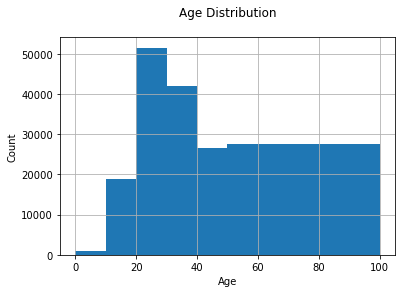

In [40]:
#checking the Age distribution
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The most active users are in the age bracket between 20 to 30 years.

Text(0.5, 1.0, 'Outliers present in the Age column')

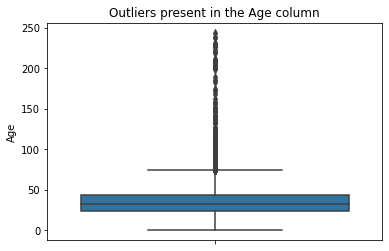

In [41]:
#checking for outliers in the age column using a boxplot
sns.boxplot(y='Age', data=users)
plt.title('Outliers present in the Age column')

Looking at the distribution plot the age is skewed to the right and has outliers. Replacing the missing age values and values less than 10 and greater than 80 with the median will be the robust approach since it's not sensitive to extreme values compared to using the mean.

In [42]:
#checking all values present in the Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Text(0.5, 1.0, 'Age Distribution Plot')

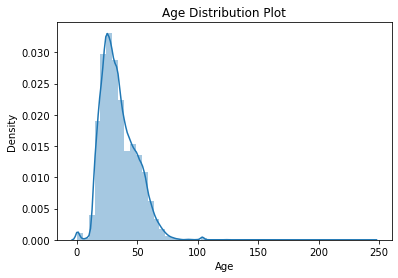

In [43]:
#plotting a distribution plot to discover the relevant age bracket 
sns.distplot(users.Age)
plt.title('Age Distribution Plot')

Evidently, users with ages less than 10 and above 80 are not an appropriate target for our book recommendation system since we assume they will not be able to access a library or use the recommendation system.

In [44]:
# Select rows where the age column is greater than 10 and less than 80
users_filtered = users[(users['Age'] >= 10) & (users['Age'] <= 80)]

In [45]:
# calculating the median for the required ages
median = users_filtered['Age'].median()
median

32.0

In [46]:
# Replace the entries less than 10 or greater than 80 with the median
users.loc[(users['Age'] < 10) | (users['Age'] > 80), 'Age'] = median

In [47]:
# Replace missing values in the "age" column with the median age
users['Age'] = users['Age'].fillna(median)

In [48]:
# convert the age column to int
users['Age'] = pd.to_numeric(users['Age'], downcast='integer')

In [49]:
print(sorted(list(users['Age'].unique())))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


In [50]:
#confirming that the missing values have been dealt with
users.isna().sum()

User-ID    0
Age        0
City       0
State      0
Country    0
dtype: int64

In [51]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int8  
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(1), int8(1), object(3)
memory usage: 8.8+ MB


### 3.2 Books Dataset

In [52]:
#checking the shape of the books dataset before dealing with erraneous ISBN values
books.shape

(271360, 8)

To evaluate further if there are any duplicates in the isbn column, we now convert all alphabets contained into uppercase and remove white spaces case for consistency.

In [53]:
#converting the books ISBN numbers to upper string and removing any white spaces
books['ISBN'] = books['ISBN'].str.upper().str.replace(' ', '')

In [54]:
#checking for duplicates 
books['ISBN'].duplicated().sum()

314

> [Books dataset](http://localhost:8888/notebooks/data/BX-Books.csv)

   * 271360 books
   * 314 duplicates
   

We also notice that a number of the isbn's have erroneous values that need to be dealt with. Typically an isbn should be of length 10. Therefore, for isbn less than 10 we pad it with 0's at the beginning, isbn greater than 10 we strip the extra numbers, and use a regular expression to try to extract the first 10 characters of the ISBN that consist only of digits and 'X' or 'x'   

In [55]:
#function to correct the ISBN that are not in correct format

def correct_isbn(isbn):
    # Convert the ISBN to a string, in case it was passed as an integer or float
    isbn = str(isbn)
    # String to use for padding the ISBN with zeros
    fill = "0"
    # Check if the ISBN is less than 10 characters
    if len(isbn) < 10:
        # Calculate the number of characters missing from the ISBN
        missing = 10 - len(isbn)
        # Pad the beginning of the ISBN with the fill string
        new_isbn = (fill * missing) + isbn
        # Return the padded ISBN
        return new_isbn
    # Check if the ISBN is greater than 10 characters
    elif len(isbn) > 10:
        # Try to use a regular expression to extract the first 10 characters of the ISBN
        # that consist only of digits and 'X' or 'x'
        try:
            # Regular expression pattern to match 10 digits and 'X' or 'x'
            pattern = r"^[0-9Xx]{10}"
            # Search for a match in the ISBN
            result = re.search(pattern, isbn)
            # Extract the first 10 characters that match the pattern
            new_isbn = result.group(0)
            # Return the extracted ISBN
            return new_isbn
        # If the regular expression fails, catch the exception and return the original ISBN
        except:
            # Print the original ISBN
            print(isbn)
            # Return the original ISBN
            return isbn

    # If the ISBN is already 10 characters, return it as is
    return isbn


In [56]:
# apply the function to the books ISBN column
books['ISBN'] = books['ISBN'].apply(correct_isbn)

Comparing the books dataset and extra_books obtained from google books API, we notice that our books dataset has extra 2 books. 
To correct this, write a function that will only pick the first 10 digits of the isbn

In [57]:
# Create a list of ISBNs from 'join_isbn_10' column
api_isbns = books_extra['join_isbn_10'].to_list()

In [58]:
# Select rows from the 'books' DataFrame where the 'ISBN' column value is not in the 'api_isbns' list
selected_rows = books.query('ISBN not in @api_isbns')
selected_rows

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [59]:
import re

# create a function to obtain the isbn
def extract_isbn(isbn):
    # Use a regular expression to extract the first 10 digits of the ISBN
    pattern = r"^[0-9]{10}"
    result = re.search(pattern, isbn)
    # Return the extracted ISBN, or the original ISBN if no match is found
    return result.group(0) if result else isbn

In [60]:
books['ISBN'] = books['ISBN'].apply(extract_isbn)

In [61]:
# dropping duplicates
books.drop_duplicates(subset=['ISBN'], inplace=True)

In [62]:
#checking the shape of the new dataset after dealing with duplicates
books.shape

(271044, 8)

In [63]:
# shape of books sourced from google books API
books_extra.shape

(271044, 10)

In [64]:
# confirm that extra books and books have the same isbn(books)
selected_rows = books.query('ISBN not in @api_isbns')
selected_rows

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


### 3.3 Merged books and extra_books(books_data)

We now merge the books and extra_books dataset

In [65]:
#merge books dataset to books_extra
books_data = books.merge(books_extra, right_on = 'join_isbn_10', left_on = 'ISBN', how = 'inner')

In [66]:
#Instantiate the 'DescribeData' class for the merged dataset
bk = DescribeData(books_data)

In [67]:
bk.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [68]:
bk.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271044 entries, 0 to 271043
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271044 non-null  object 
 1   Book-Title           271044 non-null  object 
 2   Book-Author          271043 non-null  object 
 3   Year-Of-Publication  271044 non-null  object 
 4   Publisher            271042 non-null  object 
 5   Image-URL-S          271044 non-null  object 
 6   Image-URL-M          271044 non-null  object 
 7   Image-URL-L          271041 non-null  object 
 8   authors              210684 non-null  object 
 9   published_date       212589 non-null  object 
 10  description          180298 non-null  object 
 11  isbn_10              212653 non-null  object 
 12  isbn_13              179739 non-null  object 
 13  page_count           211385 non-null  float64
 14  categories           199011 non-null  object 
 15  maturity_rating  

In [69]:
print(bk.missing)

There are a total of 607561 missing values in the DataFrame.

ISBN                       0
Book-Title                 0
Book-Author                1
Year-Of-Publication        0
Publisher                  2
Image-URL-S                0
Image-URL-M                0
Image-URL-L                3
authors                60360
published_date         58455
description            90746
isbn_10                58391
isbn_13                91305
page_count             59659
categories             72033
maturity_rating        58303
language               58303
join_isbn_10               0
dtype: int64


In [70]:
# define class for data cleaning
class DataCleaning:
    def __init__(self, data):
        self.data = data
        
    def drop_null_rows(self):
        """Drops rows with null values."""
        self.data = self.data.dropna()
        return self.data

    def drop_duplicate_rows(self):
        """Drops duplicate rows."""
        self.data = self.data.drop_duplicates()
        return self.data

    def handle_missing_values(self, column, method, value=None):
        """Handles missing values in a specified column.
        
        The method parameter take one of the following:
        "drop": Drops rows with missing values in the specified column.
        "fill": Fills missing values with the specified value.
        "interpolate": Interpolates missing values using linear interpolation.
        """
        if method == "drop":
            self.data = self.data.dropna(subset=[column])
        elif method == "fill":
            self.data[column] = self.data[column].fillna(value)
        elif method == "interpolate":
            self.data[column] = self.data[column].interpolate()
        else:
            raise ValueError("Invalid value for method parameter. Valid values are 'drop', 'fill', and 'interpolate'.")
        return self.data

    def convert_column_data_type(self, column, data_type):
        """Converts the data type of a specified column."""
        self.data[column] = self.data[column].astype(data_type)
        return self.data

In [71]:
#Instantiate the 'datacleaning' class for the merged dataset
data_cleaning = DataCleaning(books_data)

In [72]:
#dropping rows with null values in the description column
books_data = data_cleaning.handle_missing_values(column="description", method="drop")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,['Amy Tan'],1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",0399135782,9780399135781.0,428.0,['Fiction'],NOT_MATURE,en,0399135782


All entries with no description are dropped because it is a critical feature that will be used in our recommendation system.

In [73]:
#dropping unwanted columns from the merged dataset
books_data=books_data.drop(['Image-URL-L', 'Image-URL-M','isbn_10', 'isbn_13','join_isbn_10'], axis=1)
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,['Amy Tan'],1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,['Fiction'],NOT_MATURE,en


In [74]:
#checking for missing values after dropping unwanted columns
books_data.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
Image-URL-S               0
authors                1422
published_date           19
description               0
page_count              510
categories             3977
maturity_rating           0
language                  0
dtype: int64

In [75]:
#checking the years of publication
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1943, 1923, 1942, 1939, 2030, 1949, 1932, 1929, 1927, 1936,
       1931, 1938, 1914, 1910, 1933, 1911, 2050, 1902, 2038, 2010, 1901,
       1921, 1935, '2000', '1995', '2004', '1990', '1994', '1989', '2002',
       '1983', '1993', '1976', '1999', '1998', '1996', '1982', '1997',
       '2001', '1992', '1968', '1977', '1984', '1988', '2003', '1963',
       '1986', '1956', '0', '1981', '1991', '1974', '1985', '1978',
       '1987', '1979', '1980', '1969', '1961', '1965', '1939', '1975',
       '1958', '1973', '1950', '1953', '1971', '1966', '1959', 

In [76]:
#investigating the rows having 'DK Publishing Inc' as year Of Publication
books_data.loc[books_data['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
209344,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,['Michael Teitelbaum'],2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en
221454,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,"['James Buckley (Jr.)', 'Michael Teitelbaum']",2000,"Meet the artists, writers and others who make X - Men comic books come to life! Includes exclusive X - Men art! Stunning photographs combine with lively illustrations and engaging, age - appropriate stories in DK Readers, a multilevel reading program guaranteed to capture children's interest while developing their reading skills and general knowledge.",54.0,['Graphic novels'],NOT_MATURE,en


It can be observed that there are some incorrect entries in Year of Publication column since publisher names 'DK Publishing Inc' has been incorrectly recorded as Year-Of-Publication in dataset due to some errors in csv file. 

In [77]:
#Since bookAuthor is incorrectly loaded with publication year; making required corrections
#ISBN '0789466953'
books_data.loc[books_data.ISBN == '0789466953','Year-Of-Publication'] = 2000
books_data.loc[books_data.ISBN == '0789466953','Book-Author'] = "James Buckley"
books_data.loc[books_data.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books_data.loc[books_data.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books_data.loc[books_data.ISBN == '078946697X','Year-Of-Publication'] = 2000
books_data.loc[books_data.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books_data.loc[books_data.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books_data.loc[books_data.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking that the errors have been corrected
books_data.loc[(books_data.ISBN == '0789466953') | (books_data.ISBN == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
209344,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,['Michael Teitelbaum'],2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en
221454,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,"['James Buckley (Jr.)', 'Michael Teitelbaum']",2000,"Meet the artists, writers and others who make X - Men comic books come to life! Includes exclusive X - Men art! Stunning photographs combine with lively illustrations and engaging, age - appropriate stories in DK Readers, a multilevel reading program guaranteed to capture children's interest while developing their reading skills and general knowledge.",54.0,['Graphic novels'],NOT_MATURE,en


In [78]:
#investigating the rows having 'Gallimard' as yearOfPublication
books_data.loc[books_data['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
220513,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,['Jean-Marie Gustave Le ClÃ©zio'],2002,"Deux enfants vivent une expÃ©rience qui bouleverse leur vie : Petite Croix, jeune aveugle en quÃªte de la couleur bleue, dÃ©couvre la beautÃ© du monde au cours d'un Ã©tonnant voyage intÃ©rieur, tandis que Gaspar, Ã©levÃ© dans une ville, se voit rÃ©vÃ©ler la libertÃ© du nomadisme... Des histoires insolites oÃ¹ les enfants sont des magiciens qui nous entraÃ®nent de l'autre cÃ´tÃ© du miroir. RÃ©cits initiatiques, passages d'un monde Ã un autre, ces nouvelles poÃ©tiques semblent nÃ©es du rÃªve d'un Ã©crivain.",132.0,['Fiction'],NOT_MATURE,fr


In [79]:
#making required corrections for Gallimard while keeping other fields intact
books_data.loc[books_data.ISBN == '2070426769','Year-Of-Publication'] = 2003
books_data.loc[books_data.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books_data.loc[books_data.ISBN == '2070426769','Publisher'] = "Gallimard"
books_data.loc[books_data.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

#rechecking that the corrections have been made
books_data.loc[books_data.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
220513,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,['Jean-Marie Gustave Le ClÃ©zio'],2002,"Deux enfants vivent une expÃ©rience qui bouleverse leur vie : Petite Croix, jeune aveugle en quÃªte de la couleur bleue, dÃ©couvre la beautÃ© du monde au cours d'un Ã©tonnant voyage intÃ©rieur, tandis que Gaspar, Ã©levÃ© dans une ville, se voit rÃ©vÃ©ler la libertÃ© du nomadisme... Des histoires insolites oÃ¹ les enfants sont des magiciens qui nous entraÃ®nent de l'autre cÃ´tÃ© du miroir. RÃ©cits initiatiques, passages d'un monde Ã un autre, ces nouvelles poÃ©tiques semblent nÃ©es du rÃªve d'un Ã©crivain.",132.0,['Fiction'],NOT_MATURE,fr


In [80]:
# preview
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1943, 1923, 1942, 1939, 2030, 1949, 1932, 1929, 1927, 1936,
       1931, 1938, 1914, 1910, 1933, 1911, 2050, 1902, 2038, 2010, 1901,
       1921, 1935, '2000', '1995', '2004', '1990', '1994', '1989', '2002',
       '1983', '1993', '1976', '1999', '1998', '1996', '1982', '1997',
       '2001', '1992', '1968', '1977', '1984', '1988', '2003', '1963',
       '1986', '1956', '0', '1981', '1991', '1974', '1985', '1978',
       '1987', '1979', '1980', '1969', '1961', '1965', '1939', '1975',
       '1958', '1973', '1950', '1953', '1971', '1966', '1959', 

> Evidently,the data type of the year of publication are not consistently integers. 

In [81]:
# Converting the 'Year-Of-Publication' column to integers
books_data['Year-Of-Publication'] = pd.to_numeric(books_data['Year-Of-Publication'], errors='coerce')

In [82]:
# checking on rows with year of publication as 0
books_data.loc[books_data['Year-Of-Publication'] == 0]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda Del Fiume Piedra,P Coelho,0,Fabbri - RCS Libri,http://images.amazon.com/images/P/8845229041.01.THUMBZZZ.jpg,['Paulo Coelho'],1996,"Pilar ritrova a Madrid l'amico dell'infanzia. Questi ha girato il mondo ed ÃÂ¨ poi entrato in seminario, dove si dice abbia fatto miracoli. Pilar ÃÂ¨ una donna passionale, ma delusa dalla vita. Con l'amico d'infanzia compie un viaggio di sei giorni durante il quale la donna ritrova se stessa attraverso una riflessione mistico-iniziatica. I due si recano a Lourdes dove cementeranno il loro amore alla luce di una fede che esalta i valori della missione nel mondo.",216.0,['Fiction'],NOT_MATURE,it
646,0590021117,Little House On the Prairie,Laura Ingall Wilder,0,Scholastic Inc,http://images.amazon.com/images/P/0590021117.01.THUMBZZZ.jpg,['Laura Ingalls Wilder'],1953,"A family travels from the big woods of Wisconsin, to a new home on the praire, where they build a house, meet neighboring Indians, build a well, and fight a praire fire.",221.0,['Families'],NOT_MATURE,en
728,2070362388,Ravage,Rene Barjavel,0,Gallimard French,http://images.amazon.com/images/P/2070362388.01.THUMBZZZ.jpg,['RenÃÂ© Barjavel'],1972,"De l'autre cÃÂ´tÃÂ© de la Seine une coulÃÂ©e de quintessence enflammÃÂ©e atteint, dans les sous-sols de la caserne de Chaillot, ancien TrocadÃÂ©ro, le dÃÂ©pÃÂ´t de munitions et le laboratoire de recherches des poudres. Une formidable explosion entrouvre la colline. Des pans de murs, des colonnes, des rochers, des tonnes de dÃÂ©bris montent au-dessus du fleuve, retombent sur la foule agenouillÃÂ©e qui rÃÂ¢le son adoration et sa peur fendent les crÃÂ¢nes, arrachent les membres, brisent les os. Un ÃÂ©norme bloc de terre et de ciment aplatit d'un seul coup la moitiÃÂ© des fidÃÂ¨les de la paroisse du Gros-Caillou. En haut de la Tour, un jet de flammes arrache l'ostensoir des mains du prÃÂªtre ÃÂ©pouvantÃÂ©.",313.0,['Fiction'],NOT_MATURE,fr
732,2266033689,Le Diable Au Corps,Raymond Radiguet,0,Presses Pocket French,http://images.amazon.com/images/P/2266033689.01.THUMBZZZ.jpg,['Raymond Radiguet'],1990,"Pendant la premiÃÂ¨re guerre mondiale, FranÃÂ§ois, un lycÃÂ©en, fait la connaissance de Marthe, une jeune femme de dix-huit ans. Celle-ci est fiancÃÂ©e ÃÂ Jacques, un soldat qui se bat sur le front. Au mÃÂ©pris des commÃÂ©rages, FranÃÂ§ois et Marthe vont devenir amants. Mais FranÃÂ§ois n'est-il pas trop jeune pour s'engager dans une telle liaison ?",206.0,NaN,NOT_MATURE,fr
797,0718144538,Shattered Uk,Dick Francis,0,Michael Joseph Ltd,http://images.amazon.com/images/P/0718144538.01.THUMBZZZ.jpg,['Dick Francis'],2000,"Gerard Logan finds that when his jockey friend dies following a fall at the Cheltenham races, he is involved in a desperate search for a stolen video tape which embroils him in more life-threatening hazards than does his work as a widely-acclaimed glass-blower.",271.0,['Detective and mystery stories'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270082,0517209802,Christmas Memories With Recipes,Compilation,0,Random House,http://images.amazon.com/images/P/0517209802.01.THUMBZZZ.jpg,NaN,1988,25 of today's master chefs and leading food writers share their holiday food recollections.,340.0,['Christmas'],NOT_MATURE,en
270168,0571204163,Headlong,Michael Frayn,0,Faber Faber Inc,http://images.amazon.com/images/P/0571204163.01.THUMBZZZ.jpg,['Michael Frayn'],1999,"An unlikely con man wagers wife, wealth, and sanity in pursuit of an elusive Old Master. Invited to dinner by the boorish local landowner, Martin Clay, an easily distracted philosopher, and his art-historian wife are asked to assess three dusty paintings blocking the draught from the chimney. But hiding beneath the soot is nothing less-Martin believes-than a lost work by Bruegel. So begin

> we have a total of 1991 rows that lack the Year-Of-Publication, but looking at the published date we can obtain the Year-Of-Publication.

In [83]:
books_data['Year-Of-Publication']=pd.to_numeric((books_data['Year-Of-Publication']), errors='coerce')

print(sorted(books_data['Year-Of-Publication'].unique()))

[0, 1378, 1901, 1902, 1909, 1910, 1911, 1914, 1920, 1921, 1923, 1924, 1925, 1927, 1929, 1930, 1931, 1932, 1933, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2030, 2038, 2050]


In [84]:

# Replace values where the "Year-Of-Publication" is 0 with the corresponding value in the "published-data" column
books_data["Year-Of-Publication"] = books_data["Year-Of-Publication"].mask(books_data["Year-Of-Publication"] == 0, books_data["published_date"])


In [85]:
books_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       '1996', 1970, 1976, '1953', 1962, 1971, '1972', '1990', '2000',
       '1998', '1998-01', '1991', 1960, '1993', '1973', 1974, '1999',
       '1997', 1920, 1973, '2002-02', 1972, '1968', '1977', 1959, '1992',
       1953, '1986', 1951, '1994', '1980', '1987', '1985', '2001', 1964,
       1968, 1969, 1954, 1950, '1913', '1959', 1967, '1979', 2005, '1976',
       1957, '1984', '1983', '1965', '1951', 1956, '1995-10-01',
       '1995-01', '1994-01', '1930', '1995', '1978', 1940, 1937, '1989',
       '2004', 1963, 1966, '1982', 1955, '2000-03-02', '1961', '1963',
       '2002', 1952, '1992-10-13', '1981', 1946, '2010-07-27',
       '1998-03-01', 1930, '1988', '1999-01', '1962', '1999-04-01',
       '1999-09', '1975', '1997-01-07', 1925, '1974', '1969', '1948',
       '

In [86]:
# Convert the 'Year-Of-Publication' column to a string type
books_data['Year-Of-Publication'] = books_data['Year-Of-Publication'].astype(str)


In [87]:
# function to correct the Year-Of-Publication column

def date_correction(date):
    # Use a try-except block to catch any exceptions that might occur
    try:
        # Define a regular expression pattern to match four consecutive digits at the start of the string
        pattern = r'^\d{4}'
        
        # Use the re.search function to search for the pattern in the date string
        search = re.search(pattern, date)
        
        # Return the matched string if found
        return search.group(0)
    except:
        # If an exception occurs, print the original date string
        print(date)

In [88]:
# preview of unique years in Year-Of-Publication
books_data['Year-Of-Publication'] = books_data['Year-Of-Publication'].apply(date_correction)
books_data['Year-Of-Publication'].unique()

19??
nan
nan
199?
19??
199?
19??


array(['2002', '1991', '1999', '2000', '1996', '1988', '2004', '1998',
       '1994', '2001', '1997', '2003', '1993', '1983', '1979', '1995',
       '1982', '1992', '1986', '1978', '1987', '1981', '1990', '1989',
       '1961', '1958', '1984', '1977', '1985', '1980', '1975', '1965',
       '1941', '1970', '1976', '1953', '1962', '1971', '1972', '1960',
       '1973', '1974', '1920', '1968', '1959', '1951', '1964', '1969',
       '1954', '1950', '1913', '1967', '2005', '1957', '1956', '1930',
       '1940', '1937', '1963', '1966', '1955', '1952', '1946', '2010',
       '1925', '1948', '1947', '1945', '1943', '1923', '2007', '2008',
       '1942', '1939', None, '2030', '2006', '2022', '1949', '1932',
       '1929', '1934', '2011', '1927', '1936', '1931', '1938', '1908',
       '1922', '1914', '1910', '1935', '1933', '2012', '1911', '2050',
       '1859', '1902', '2038', '1944', '2018', '1901', '1921', '2009',
       '1887', '1924', '1909', '1378'], dtype=object)

In [89]:
# function to clean the Year-Of-Publication

def clean_year_column(year):
    # Return None if the year is None
    if year is None:
        return None
    
    # Replace any question marks with empty strings
    year = year.replace('?', '')
    
    # Return the year as an integer, or None if the year is empty
    return int(year) if year else None

In [90]:
books_data['Year-Of-Publication'] = books_data['Year-Of-Publication'].apply(clean_year_column)
books_data['Year-Of-Publication'].unique()

array([2002., 1991., 1999., 2000., 1996., 1988., 2004., 1998., 1994.,
       2001., 1997., 2003., 1993., 1983., 1979., 1995., 1982., 1992.,
       1986., 1978., 1987., 1981., 1990., 1989., 1961., 1958., 1984.,
       1977., 1985., 1980., 1975., 1965., 1941., 1970., 1976., 1953.,
       1962., 1971., 1972., 1960., 1973., 1974., 1920., 1968., 1959.,
       1951., 1964., 1969., 1954., 1950., 1913., 1967., 2005., 1957.,
       1956., 1930., 1940., 1937., 1963., 1966., 1955., 1952., 1946.,
       2010., 1925., 1948., 1947., 1945., 1943., 1923., 2007., 2008.,
       1942., 1939.,   nan, 2030., 2006., 2022., 1949., 1932., 1929.,
       1934., 2011., 1927., 1936., 1931., 1938., 1908., 1922., 1914.,
       1910., 1935., 1933., 2012., 1911., 2050., 1859., 1902., 2038.,
       1944., 2018., 1901., 1921., 2009., 1887., 1924., 1909., 1378.])

In [91]:
#replacing years above 2004 and non-four digit year values with the median
books_data.loc[(books_data['Year-Of-Publication'] > 2004) | (~books_data['Year-Of-Publication'].astype(str).str.match('\d{4}')),'Year-Of-Publication'] = np.NAN

#replacing NaNs with median value of Year-Of-Publication
books_data['Year-Of-Publication'].fillna(round(books_data['Year-Of-Publication'].median()), inplace=True)

In [92]:
books_data['Year-Of-Publication'].isna().sum()

0

In [93]:
books_data['Year-Of-Publication'].unique()

array([2002., 1991., 1999., 2000., 1996., 1988., 2004., 1998., 1994.,
       2001., 1997., 2003., 1993., 1983., 1979., 1995., 1982., 1992.,
       1986., 1978., 1987., 1981., 1990., 1989., 1961., 1958., 1984.,
       1977., 1985., 1980., 1975., 1965., 1941., 1970., 1976., 1953.,
       1962., 1971., 1972., 1960., 1973., 1974., 1920., 1968., 1959.,
       1951., 1964., 1969., 1954., 1950., 1913., 1967., 1957., 1956.,
       1930., 1940., 1937., 1963., 1966., 1955., 1952., 1946., 1925.,
       1948., 1947., 1945., 1943., 1923., 1942., 1939., 1949., 1932.,
       1929., 1934., 1927., 1936., 1931., 1938., 1908., 1922., 1914.,
       1910., 1935., 1933., 1911., 1859., 1902., 1944., 1901., 1921.,
       1887., 1924., 1909., 1378.])

In [94]:
# Instantiate the 'datacleaning' class for the 'books_data' DataFrame
data_cleaning = DataCleaning(books_data)

In [95]:
# Convert the "year-of-publication" column to integer
#books_data['Year-Of-Publication'] = books_data['Year-Of-Publication'].apply(int)
books_data = data_cleaning.convert_column_data_type('Year-Of-Publication', int)
print(sorted(books_data['Year-Of-Publication'].unique())) 

[1378, 1859, 1887, 1901, 1902, 1908, 1909, 1910, 1911, 1913, 1914, 1920, 1921, 1922, 1923, 1924, 1925, 1927, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]


In [96]:
#dropping the published date column since it will not be required for analysis
books_data = books_data.drop(['published_date'], axis=1)
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']","Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]","Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,['E. J. W. Barber'],"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,['Amy Tan'],"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,['Fiction'],NOT_MATURE,en


In [97]:
books_data.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
Image-URL-S               0
authors                1422
description               0
page_count              510
categories             3977
maturity_rating           0
language                  0
dtype: int64

In [98]:
#exploring 'publisher' column
books_data.loc[books_data.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
128958,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg,['Linnea Sinclair'],"Be careful what you wish for. You might get it... Her ship's in shambles, her boyfriend's dumped her and she's frankly out of funds. Captain Trilby Elliot hopes her luck has changed when a high-tech fightercraft crash lands at her repair site. Finders keepers. She can sell the ship as salvage, pocket the profits. Except for one small problem: the pilot, Rhis, is still alive and intent on commandeering her ship. And another much larger problem: someone very powerful and very important wants Trilby Elliot dead.",354.0,['Fiction'],NOT_MATURE,en


In [99]:
#Filling Nan of Publisher with its publisher
books_data.Publisher.fillna('Bantam', inplace=True)

In [100]:
#exploring 'Page count' column
books_data.loc[books_data.page_count.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.01.THUMBZZZ.jpg,['Jane Austen'],"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",NaN,NaN,NOT_MATURE,en
279,0394586239,Possession: A Romance,A. S. Byatt,1990,Random House Inc,http://images.amazon.com/images/P/0394586239.01.THUMBZZZ.jpg,['Antonia Susan Byatt'],"In 1986 two young English scholars stumble upon a remarkable discovery: a hitherto unsuspected relationship between the Browningesque 19th century poet Randolph Henry Ash, and his contemporary Christabel LaMotte. Their research reveals uncanny parallels with their own lives and culminates in the exhumation of a poet's corpse.",NaN,['Biographers'],NOT_MATURE,en
2572,0671705997,Easy to Kill,Agatha Christie,1991,Pocket Books,http://images.amazon.com/images/P/0671705997.01.THUMBZZZ.jpg,['Agatha Christie'],"An elderly lady suspected of murder in the sleepy village of Wychwood dies--another victim of an unseen hand. Since too many accidents and unexplained deaths have occurred, even for a town with a history of witchcraft, policeman Luke Fitzwilliam vows to discover the reason--and finds a very cunning killer.",NaN,NaN,NOT_MATURE,en
2763,0671743562,"Dreams of the Raven (Star Trek, No 34)",Carmen Carter,1991,Star Trek,http://images.amazon.com/images/P/0671743562.01.THUMBZZZ.jpg,['Carmen Carter'],Captain Kirk and the crew of the Enterprise struggle against an unknown deadly enemy after a mysterious attack cripples the starship and leaves Dr. McCoy without a memory,NaN,['Fiction'],NOT_MATURE,en
4014,0399226907,The Very Hungry Caterpillar Board Book,Eric Carle,1994,Philomel Books,http://images.amazon.com/images/P/0399226907.01.THUMBZZZ.jpg,NaN,"Colorful and full of imagination, the world of Eric Carle is a delight! Sings songs, cook, and create with the book box based of the worl of Eric Carle.",NaN,['Caterpillars'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
267878,0671452193,TILLY,Kelli M. Gary,1982,Pocket,http://images.amazon.com/images/P/0671452193.01.THUMBZZZ.jpg,['Catherine Cookson'],"Refusing to relinquish her dreams and undaunted in her will to survive, Tilly Trotter is forced to flee her home in the rural countryside of nineteenth-century England after she is falsely accused of practicing witchcraft",NaN,['Fiction'],NOT_MATURE,en
270769,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.amazon.com/images/P/082811420X.01.THUMBZZZ.jpg,['Bill J. Bonnstetter'],"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",NaN,NaN,NOT_MATURE,en
270814,0441216005,Escape Velocity,Christopher Stasheff,1984,Ace Books,http://images.amazon.com/images/P/0441216005

In [101]:
# Replace any NaN values with the median value
books_data['page_count'].fillna(books_data['page_count'].median(), inplace=True)

In [102]:
# Convert the 'page_count' to numeric data type
books_data['page_count'] = pd.to_numeric(books_data['page_count'], errors='coerce')
# Convert the 'float_column' to integer data type
books_data['page_count'] = books_data['page_count'].round().astype(int)
# preview data set
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']","Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]","Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,['E. J. W. Barber'],"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,['Amy Tan'],"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428,['Fiction'],NOT_MATURE,en


In [103]:
#exploring the categories column
books_data.loc[books_data.categories.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
33,3442353866,Der Fluch der Kaiserin. Ein Richter- Di- Roman.,Eleanor Cooney,2001,Goldmann,http://images.amazon.com/images/P/3442353866.01.THUMBZZZ.jpg,"['Eleanor Cooney', 'Daniel Altieri']",Im China des Jahres 671 gelingt Richter Di die Flucht vor der skrupellosen Kaiserin Wu in die Hafenstadt Kanton. Doch auch dort ist er nicht sicher.,507,NaN,NOT_MATURE,de
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.01.THUMBZZZ.jpg,['Jane Austen'],"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",260,NaN,NOT_MATURE,en
190,3423241489,Ist mein Hintern wirklich so dick? Tagebuch einer empfindsamen Frau.,Arabella Weir,1998,Dtv,http://images.amazon.com/images/P/3423241489.01.THUMBZZZ.jpg,['Arabella Weir'],"Jacqueline er en dygtig 35-ÃÂ¥rig kvinde, som passer sit job som konferenceplanlÃÂ¦gger i London med stor succes. Men i sin dagbog afslÃÂ¸rer hun galgenhumoristisk sit rÃÂ¦dselsfulde mindrevÃÂ¦rdskompleks og sin absolut skÃÂ¦ve selvopfattelse",239,NaN,NOT_MATURE,de
201,3596292646,Das Buch der lÃ?Â¤cherlichen Liebe.,Milan Kundera,2000,"Fischer (Tb.), Frankfurt",http://images.amazon.com/images/P/3596292646.01.THUMBZZZ.jpg,['Milan Kundera'],"Die im 'Buch der lÃÂ¤cherlichen Liebe' versammelten ErzÃÂ¤hlungen sind noch in den sechziger Jahren in Prag entstanden. In seinen ErzÃÂ¤hlungen spannt Kundera die komischsten Paare zusammen, die schlieÃÂlich in grotesken Situationen die AbsurditÃÂ¤t unserer Beziehungen erkennen mÃÂ¼ssen.",238,NaN,NOT_MATURE,de
284,0451526279,Emma (Signet Classics (Paperback)),Jane Austen,1996,Signet Classics,http://images.amazon.com/images/P/0451526279.01.THUMBZZZ.jpg,['Jane'],"Beschrijving van leven en karakter van een jong, intelligent en zelfbewust meisje uit de gegoede middenstand in Engeland omstreeks 1800.",414,NaN,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
270708,0044422814,Oceana Fine,Tom Flood,1989,Allen &amp; Unwin (Australia) Pty Ltd,http://images.amazon.com/images/P/0044422814.01.THUMBZZZ.jpg,['Tom Flood'],"A bold new novel which is part whodunit, part psychological thriller, part magical fantasy, charting the lives and decreasing fortunes of the Cleaver family.;",261,NaN,NOT_MATURE,en
270769,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.amazon.com/images/P/082811420X.01.THUMBZZZ.jpg,['Bill J. Bonnstetter'],"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",260,NaN,NOT_MATURE,en
270814,0441216005,Escape Velocity,Christopher Stasheff,1984,Ace Books,http://images.amazon.com/images/P/0441216005.01.THUMBZZZ.jpg,['Christopher Stasheff'],"Democracy is crumbling in the Interstellar Dominion Electorates and if Dar 

In [104]:
#filling NaN of categories with None
books_data.categories.fillna('None',inplace=True)

In [105]:
def categories_split(categories):
    # Convert a string representation of a list into an actual list of strings
    try:
        # Replace various substrings in the original string with others
        categories = categories\
            .replace("['", "")\
            .replace("']", "")\
            .replace("', '", ", ")\
            .replace("','", ", ")\
            .replace("' ,'", ", ")\
            .replace('["', '')\
            .replace('"]', '')\
            .replace('", "', ', ')\
            .replace('","', ', ')\
            .replace('" ,"', ', ')\
        
        # Split the resulting string into a list of strings using the split method
        categories = categories.split(", ")
        return categories
    
    # If an exception, return an empty list
    except:
        return []

In [106]:
#applying the categories_split function to the categories column
books_data['categories'] = books_data['categories'].apply(categories_split)
books_data['categories'].head()

0    [Social Science]
2         [1940-1949]
3           [Medical]
4            [Design]
5           [Fiction]
Name: categories, dtype: object

In [107]:
#separating the categories from the created list
books_data = books_data.explode(column='categories', ignore_index = True)
books_data.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']","Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]","Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,NOT_MATURE,en
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,Medical,NOT_MATURE,en


In [108]:
#exploring the authors column
books_data.loc[books_data.authors.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
302,0590481371,I Spy Spooky Night: A Book of Picture Riddles (I Spy Books),Walter Wick,1996,Scholastic,http://images.amazon.com/images/P/0590481371.01.THUMBZZZ.jpg,NaN,Rhyming verses ask readers to find hidden objects in the photographs.,31,Juvenile Nonfiction,NOT_MATURE,en
1142,0895773538,How in the World?: A Fascinating Journey Through the World of Human Ingenuity,Readers Digest,1990,Readers Digest,http://images.amazon.com/images/P/0895773538.01.THUMBZZZ.jpg,NaN,"An illustrated celebration of human ingenuity explains the underlying principles of 425 key technological innovations, revealing the secrets of lasers, holograms, and more",448,Technology & Engineering,NOT_MATURE,en
1176,0718001044,Nelson's Bedtime Bible Stories : 150 Passages from the International Children's Bible,Paul Gross,2002,Nelson Bibles,http://images.amazon.com/images/P/0718001044.01.THUMBZZZ.jpg,NaN,Includes stories from both the Old and New Testaments.,356,Juvenile Nonfiction,NOT_MATURE,en
1478,1590171012,The Magic Pudding: Being the Adventures of Bunyip Bluegum and His Friends Bill Barnacle &amp; Sam Sawnoff (New York Review Children's Collection),Norman Lindsay,2004,New York Review Children's Collection,http://images.amazon.com/images/P/1590171012.01.THUMBZZZ.jpg,NaN,"Bunyip Bluegum, an adventurous Australian koala bear, meets up with a sailor, a penguin, and their magic pudding, which is in constant danger of being stolen.",185,Juvenile Fiction,NOT_MATURE,en
1500,0913367176,Stories for the Faithful Heart,various authors,2000,"Graham, Billy Evangelistic Association",http://images.amazon.com/images/P/0913367176.01.THUMBZZZ.jpg,NaN,"Features inspirational stories by Christian authors such as Max Lucado, Billy Graham and Chuck Swindoll.",276,Christian life,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
185304,0716726041,An Introduction to Genetic Analysis,Anthony J. F. Griffiths,1996,W.H. Freeman &amp; Company,http://images.amazon.com/images/P/0716726041.01.THUMBZZZ.jpg,NaN,"This edition contains a new chapter on genomics, updated chapters on molecular genetics, new exercises that help students assimilate and apply a number of genetic principles, and a greater emphasis on human genetics.",915,Genetics,NOT_MATURE,en
185368,1931514631,Planet Ladder (Volume 2),Narushima Yuri,2002,TokyoPop,http://images.amazon.com/images/P/1931514631.01.THUMBZZZ.jpg,NaN,"Follows the adverntures of Kaguya, the fabled Princess of the Choosing, who legend says will decide which of the nine alternate Earths will be saved.",192,Comics & Graphic Novels,NOT_MATURE,en
185439,0394884973,"Walt Disney Pictures Presents the Great Mouse Detective (Disney's Wonderful World of Reading, No 55)",Not Applicable (Na ),1986,Random House Childrens Books,http://images.amazon.com/images/P/0394884973.01.THUMBZZZ.jpg,NaN,The evil Ratigan plans to kidnap the queen and replace her with a life-size toy queen through whom he will rule England; but master mouse detective Basil of Baker Street steps in to foil the plot. Based on the Disney movie of the same title.,48,Detective and mystery stories,NOT_MATURE,en
185506,0822502763,Antonyms: Hot and Cold and Other Words That Are Different As Night and Day,Joan Hanson,1972,Lerner Pubns Co (L),http://images.amazon.com/images/P/0822502763.01.THUMBZZZ.jpg,NaN,Pictures on facing pages reflect the opposite meanings of the antonyms given.,32,Juvenile Nonfiction,NOT_MATURE,en


In [109]:
# defining a fuction to handle missing data in authors column
def replace_missing_values(df):
    
 # Create a boolean mask indicating which rows in the "authors" column have missing values
 mask = df['authors'].isnull()
 
 # Get the index values for the rows where the value in the "authors" column is missing
    
 indexes = df.loc[mask, 'authors'].index
 
 # Use the index values to select the corresponding values in the "book_authors" column
 # and assign these values to the "authors" column for the rows where the value is missing
 df.loc[indexes, 'authors'] = df.loc[indexes, 'Book-Author']

In [110]:
# replacing missing authors with corresponding book-author
replace_missing_values(books_data)

In [111]:
# rechecking for missing values in authors
books_data['authors'].isna().sum()

0

In [112]:
# In the authors column we have the authors names in a list

def authors_split(authors):
    # Convert a string representation of a list into an actual list of strings
    try:
        # Replace various substrings in the original string with others
        authors = authors\
            .replace("['", "")\
            .replace("']", "")\
            .replace("', '", ", ")\
            .replace("','", ", ")\
            .replace("' ,'", ", ")\
            .replace('["', '')\
            .replace('"]', '')\
            .replace('", "', ', ')\
            .replace('","', ', ')\
            .replace('" ,"', ', ')\
        
        # Split the resulting string into a list of strings using the split method
        authors = authors.split(", ")
        return authors
    
    # If an exception, return an empty list
    except:
        return []


In [113]:
#applying the function to the authors column
books_data['authors'] = books_data['authors'].apply(authors_split)
books_data['authors'].head()

0    [Mark P. O. Morford, Robert J. Lenardon]
1                              [Carlo D'Este]
2                          [Gina Bari Kolata]
3                           [E. J. W. Barber]
4                                   [Amy Tan]
Name: authors, dtype: object

In [114]:
#separating the different authors from the created list
books_data = books_data.explode(column='authors', ignore_index = True)
books_data.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Mark P. O. Morford,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Robert J. Lenardon,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,Carlo D'Este,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,NOT_MATURE,en


In [115]:
#converting values in the maturity rating column to lowercase
books_data['maturity_rating'] = books_data['maturity_rating'].str.lower()
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Mark P. O. Morford,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,not_mature,en
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Robert J. Lenardon,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,not_mature,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,Carlo D'Este,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,not_mature,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,Gina Bari Kolata,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,Medical,not_mature,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,E. J. W. Barber,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,Design,not_mature,en


In [116]:
#confirming that all missing values have been dealt with
books_data.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
authors                0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

### Ratings Dataset

In [117]:
#cleaning the ratings ISBN column using the correct_isbn function
ratings['ISBN'] = ratings['ISBN'].apply(correct_isbn)

N3453124715
2.02.032126.2
2.264.03602.8
680ISBN359623
O6712345670
01420.01740
DITISEENSOORT
BCID694577184
2.02.033143.8
972202138.9
\0210000010"
00 14 02 5314
0316=693235
01404.30024
451q4111095
AroundinCircl
2.253000043
01402.5448X
98OISBN349917
22.40.27.39
01401.87367
0698.119116
847154136.X
2.02.010685.X
D4251666619
2.02.055078.4
0/330/25864/8
01402.5448X
DOESNOTHAVEON
 9022906116
\0432534220\""
\2842053052\""
0 7336 1053 6
0=965044153
006=0176989
01400.53204
01400.63935
01402.50948
01420.01740
01460.00129
0385=426151
089296+4502
2.02.025380.1
2.02.048170.7
2.02.053056.2
2.266.11441.7
200ISBN349922
250ISBN349920
3.406420974
3.897484862
880ISBN20553X
CARD#6920006
ISBN067172365
ISBN068481039
N3612250612
NOVELABOUTTHE
O0340824387
ZR903CX0003
84.02.05006.9
301.120/119/8
444300/64/77
2.02.032041
451UQ1079095
KEEPINGYOURKI
ISBN:08112003
301.120/210/8
301.120/231/7
301.120/262/8
301.120/263/8
ISBN:08820775
0 907 062 008
208+0676318
0 75280 122 8
2.207.50119.1
01413.048871
ASTAINZ070795
014

01400.67477
84.66400311
006=0909927
01400.14349
2813585.13/34
01400.12486
857/1761211
2.02.032459.8
\0432534220\""
2.211.032788
2.211.034.73.
2.211.034.896
2.253.15537.3
2.266.09291.X
202012889.6
220725193.4
01402.33016
444300/121/83
N044809570X
0/330/25864/8
ISBN158898809
O373.484224
2.207.24735.X
2.207.24778.3
2.207.300668
2.207.30546.5
2.207.50002.0
ISBN059050590
01400.44221
0 671 74251 5
84.66400311
014A0007016
ISBN:14010225
1971/0099/142
0_8218_0635_1
0553 505416
01402.5448X
0 907 062 008
ISBN096873513
NO44020557359
01460.00870
3.897484862
N0385292244
031226312.0
03H75713220
ISBN097188010
2.02.006187.4
2.02.006832
2.02.023930.2
2.02.048170.7
2.02.049518
2.234.02262.2
27144.2960.2
01401.87103
KAFKA(207/4)
KAFKA(906/721
LOOKING2READ
01401.6930X
\8804520159\""
85.326.2958X
B51281.2003
ISBN:01403645
2.02.035232.X
01402.80146
2.227.00202.6
014048.003X
01400.3420X
01402.31323
202062803.1
01402.3313X
0 00 612183 7
001400.000318
014.00.30859
01400.07601
01400.3731.4
01400.37322
01400.4349

In [118]:
#getting rid of the special characters present in the ISBN column
from string import punctuation
ratings['ISBN'] = ratings['ISBN'].apply(lambda x: x.translate(str.maketrans('', '', punctuation)).replace(' ', '').upper())

In [119]:
#ensuring the special characters have been dealt with
ratings['ISBN'] = ratings['ISBN'].apply(correct_isbn)

N3453124715
680ISBN359623
O6712345670
DITISEENSOORT
BCID694577184
451Q4111095
AROUNDINCIRCL
98OISBN349917
D4251666619
DOESNOTHAVEON
200ISBN349922
250ISBN349920
880ISBN20553X
CARD6920006
ISBN067172365
ISBN068481039
N3612250612
NOVELABOUTTHE
O0340824387
ZR903CX0003
451UQ1079095
KEEPINGYOURKI
ISBN08112003
ISBN08820775
ASTAINZ070795
NARRACIONES
DMGREENWOOD
JANEDENTINGER
05319V98393
451Q4789095
O8408040294
O8474238757
O8495712555
O96815005550
ISBN073941625
451P3807060
NOTAVAILABLE
ISBN068481039
067189859OBC
451Q3517095
72IV10765026
ISBN337800406
ISBN039475828
349800924SS
680ISBN349917
451CQ552095
N0553212583
NO140131183
ISBN188907105
N0553212583
NOTPROVIDED
880ISBN20553X
ISBN881174029
TBR0385495641
0451MY1011125
ISBN067172365
O6671525700
078686871B510
0451MY1011125
451E6671225
N3704320196
BCID615131059
ROO48580353
ISBN188252200
N055325112059
MAEVEBINCHY
34501944Y100
70350B2012573
451Q3761095
451Q4872095
N055327788X
393SS704064
N3453020537
N055327788X
200ISBN349922
250ISBN349920
SBN425037452

In [120]:
#ensuring ratings dataset has only books in the merged dataset for books and books extra
ratings_new = ratings[ratings.ISBN.isin(books_data.ISBN)]
ratings.shape,ratings_new.shape

((1149780, 3), (833962, 3))

It can be seen that many rows having book ISBN not part of the merged dataset for books and books extra got dropped off

In [121]:
#ensuring ratings dataset has only books in the users datset
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (833962, 3)
shape of dataset after dropping (833962, 3)


It is evident that no new user was there in the users dataset.

In [122]:
# segregating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings['Book-Rating'] == 0]

In [123]:
# Create column Rating average consisting the mean of the explicit ratings
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Total-No-Of-Users-Rated consisting the count of explicit ratings 
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [124]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21


In [125]:
# merging explicit ratings to the users dataset and books_data dataset
Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings_explicit,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,books_data,on='ISBN')

In [126]:
Final_Dataset.isna().sum()

User-ID                    0
Age                        0
City                       0
State                      0
Country                    0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
Image-URL-S                0
authors                    0
description                0
page_count                 0
categories                 0
maturity_rating            0
language                   0
dtype: int64

In [200]:
Final_Dataset.shape

(353731, 20)

In [128]:
#Instantiate the 'DescribeData' class for the 'Final_dataset' 
fd = DescribeData(Final_Dataset)

In [129]:
#checking for missing values in the combined dataset to be used for analysis
print(fd.missing)

There are a total of 0 missing values in the DataFrame.

User-ID                    0
Age                        0
City                       0
State                      0
Country                    0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
Image-URL-S                0
authors                    0
description                0
page_count                 0
categories                 0
maturity_rating            0
language                   0
dtype: int64


# 3.EXPLORATORY DATA ANALYSIS

## 3.1 Univariate Analysis

### 3.1.1 Users

In [130]:
# Create a function that visualizes the value counts of a column
def plot_top_value_counts(dataframe, column, top_n=20):
    """
    Plots a bar chart for the value counts of the top 20 values of a DataFrame column.
    
    
    """
    value_counts = dataframe[column].value_counts()
    top_value_counts = value_counts.iloc[:top_n]
    plt.figure()
    top_value_counts.plot.bar(figsize=(10, 6))
    plt.title(f"Top {top_n} value count for {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


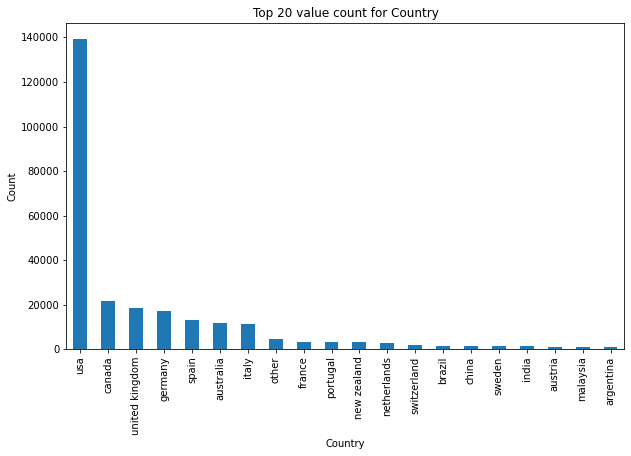

In [131]:
# plotting a countplot of cities
plot_top_value_counts(users, "Country")

> Majority of users are from the United States.

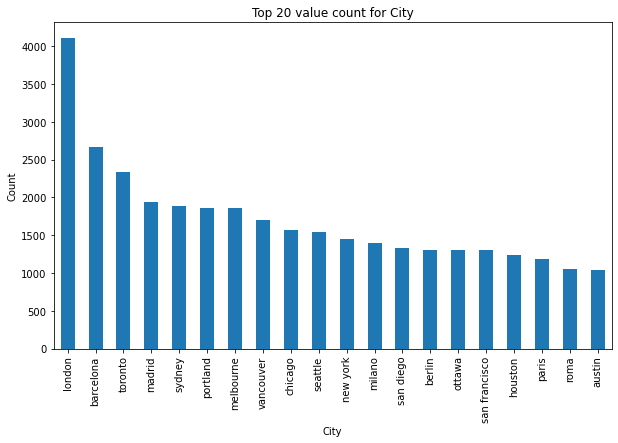

In [132]:
# plotting a countplot of states
plot_top_value_counts(users, "City")

> Most users are from london followed by barcelona.

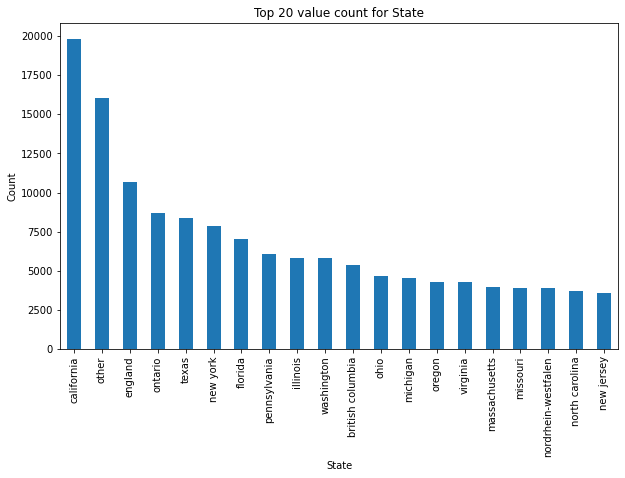

In [133]:
# plotting a countplot of Countries
plot_top_value_counts(users, "State")

>  California a state located on the west coast of the United States, is the leading state with most users.

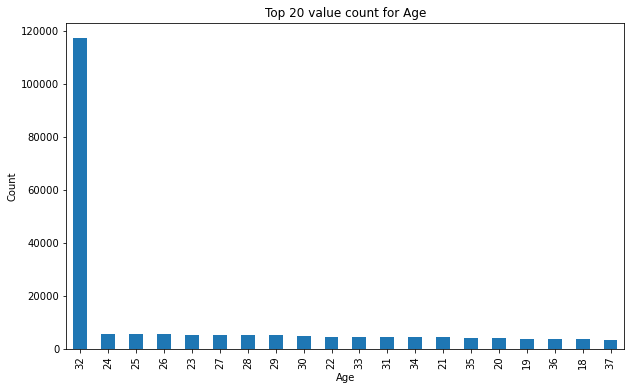

In [134]:
# plotting a countplot of users age
plot_top_value_counts(users, "Age")

> A large proportion of users are 32 years old

### 3.1.2 books_data


#### 3.1.2.1 authors

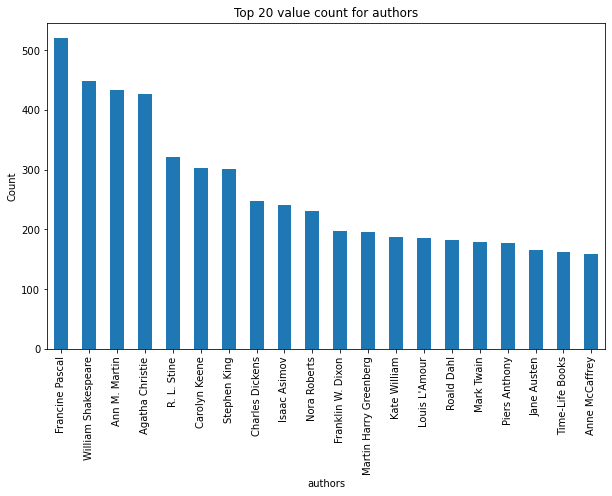

In [135]:
# plotting a countplot of Book-Author
plot_top_value_counts(books_data, "authors")

> The most recognised book authors are Francine Pascal with over 500 books, followed by William Shakespeare, Ann M. Martin and Agatha Christie.       

#### 3.1.2.2 Year-Of-Publication

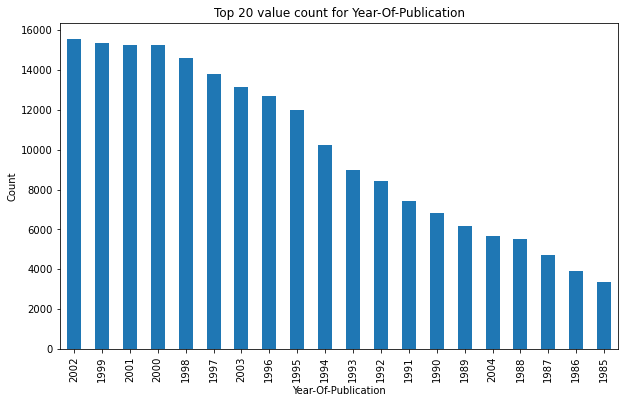

In [136]:
# plotting a countplot of Year-Of-Publication
plot_top_value_counts(books_data, "Year-Of-Publication")

> Looking at the year of publication distribution, most books were published in the early 20's and late 90's having 2002 as the leading year.

#### 3.1.2.3 Publisher

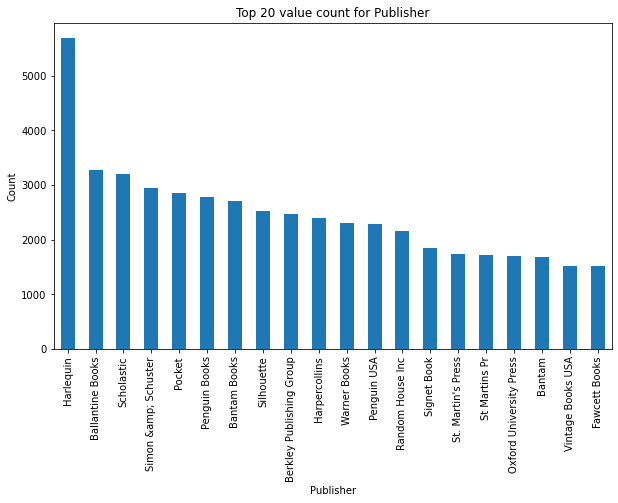

In [137]:
# plotting a countplot of book Publisher
plot_top_value_counts(books_data, "Publisher")

> Most books are published by Harlequin 

#### 3.1.2.4 categories

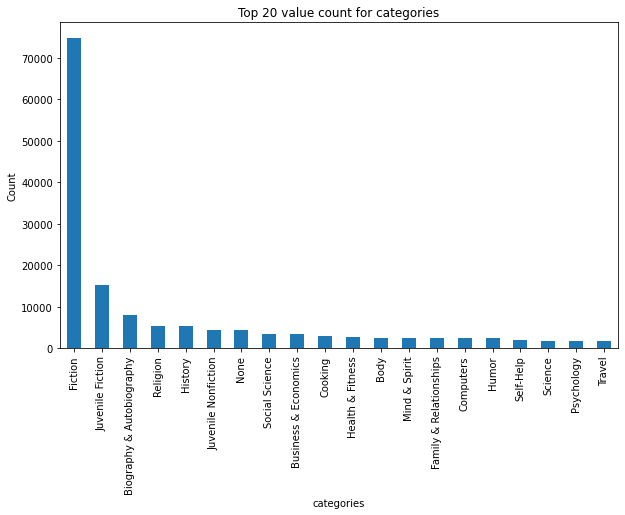

In [138]:
# plotting a countplot of book categories
plot_top_value_counts(books_data, "categories")

> Fiction is the most common category of books

#### 3.1.2.5 language

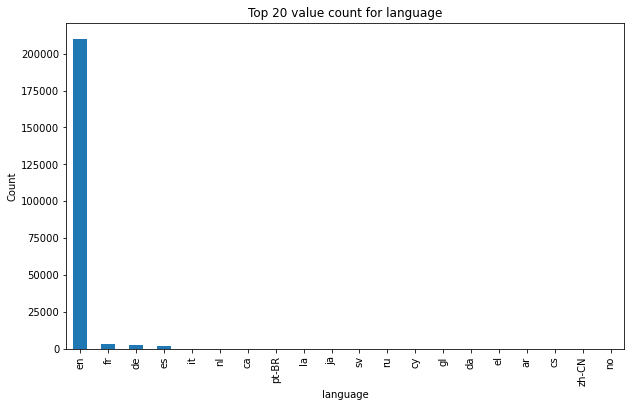

In [139]:
# plotting a countplot of book language
plot_top_value_counts(books_data, "language")

> The majority of books are written in English.

#### 3.1.2.6 description

In [140]:
# function for cleaning description column based on language

def clean_description(description, language):
    
     # Check for missing values and replace with empty string
    if pd.isnull(description):
        description = ""
        
    # Remove any HTML tags from the description
    description = re.sub(r'<[^>]*>', '', description)
    
    # Replace any non-alphabetic characters with a space
    description = re.sub(r'[^a-zA-Z]', ' ', description)
    
    # Tokenize the description
    tokens = word_tokenize(description)
    
    # Remove any stop words from the description
    stop_words = set(stopwords.words(language))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    
    # Join the tokens back into a single string
    description = ' '.join(tokens)
    
    # Remove any extra whitespace
    description = re.sub(r'\s+', ' ', description).strip()
    
    # Return the cleaned description
    return description

In [141]:
# Create a new dataframe with only rows where language is "english"
english_books = books_data[books_data['language'] == "en"]

In [142]:
# applying the cleaning function on english books
english_books['description'] = english_books['description'].apply(lambda x: clean_description(x, 'english'))

In [143]:
# WordCloud function

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(df, column, max_words=100, width=800, height=400, min_word_length=3):
    # Create a string from the specified column of the dataframe
    text = " ".join(description for description in df[column])
    
    # Generate a word cloud with the specified parameters
    wordcloud = WordCloud(max_words=max_words, width=width, height=height, min_word_length=min_word_length).generate(text)
    
    # Display the word cloud
    fig = plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

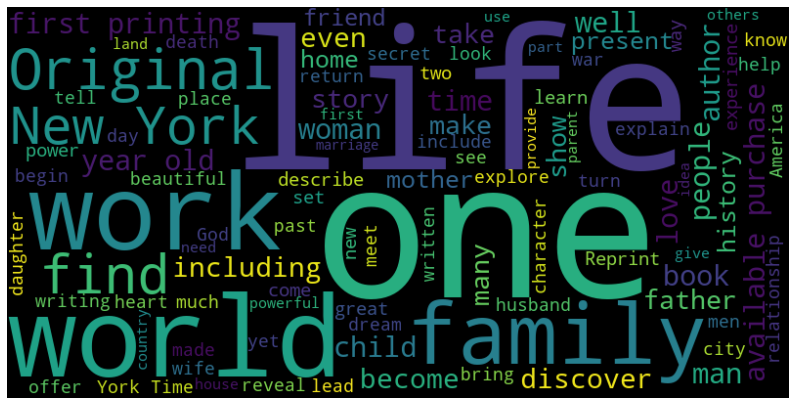

In [144]:
# wordcloud for english books
generate_wordcloud(english_books, 'description', max_words=100, width=800, height=400, min_word_length=3)

> The majority of English books under description focus on the life, family, world, and work.

### 3.1.3 ratings

In [145]:
#defining a function for plotting a countplot
def count_plot (column, dataset, heading):
    """Visualize the countplots of various dataframes with seaborn barplot
    
    Args: 
        data: dataframe of various columns and their count returned from count_plot function
        
    Returns: 
        countplot: countplot of columns and their count
    """
    plt.figure(figsize=(15,8));
    sns.countplot(y=column, data=dataset, order=pd.value_counts(dataset[column]).iloc[0:15].index);
    plt.title(heading);

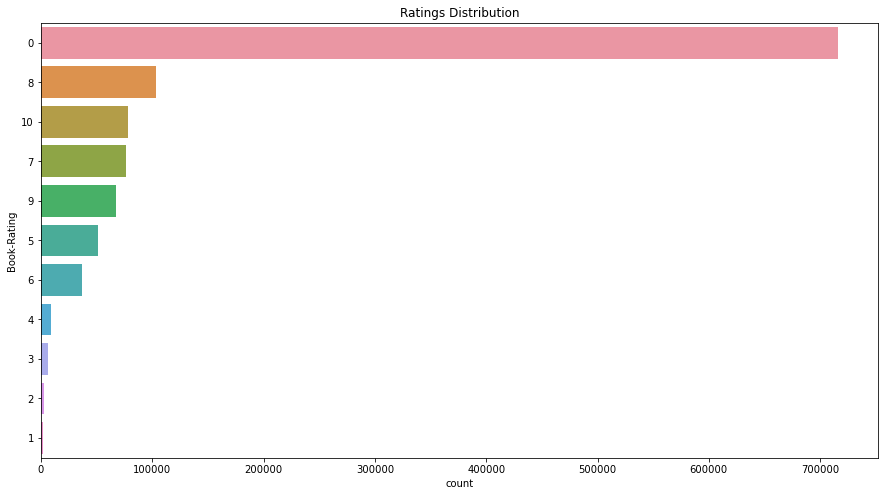

In [146]:
#checking the distribution of ratings
count_plot('Book-Rating', ratings, 'Ratings Distribution')

The ratings are unevenly distributed since majority of the ratings are 0. The ratings are either explicit, expressed on a scale of 1-10 with higher values denoting higher appreciation, or implicit, expressed by 0. Hence the need to segragate implicit and explict ratings datasets

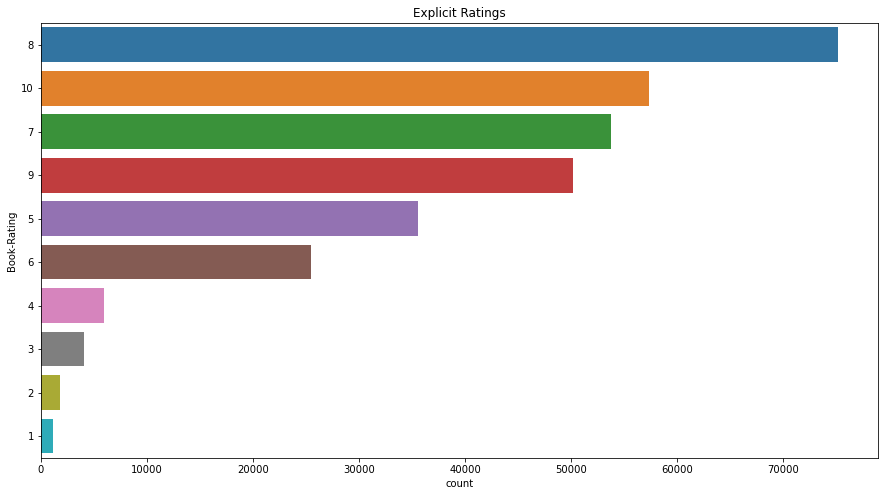

In [147]:
#plotting the explicit ratings
count_plot('Book-Rating', ratings_explicit, 'Explicit Ratings')

It can be observed that higher ratings are most common amongst users and rating 8 has been rated the highest number of times.

In [148]:
#finding the top 5 books that are rated most
rating_count = pd.DataFrame(ratings_explicit.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,490
0312195516,383
059035342X,315


Majority of the books that had a high rating are mainly of category fiction and are all novels. This shows that novels of type fiction are mainly preferred by users

### 3.1.4 Final dataset

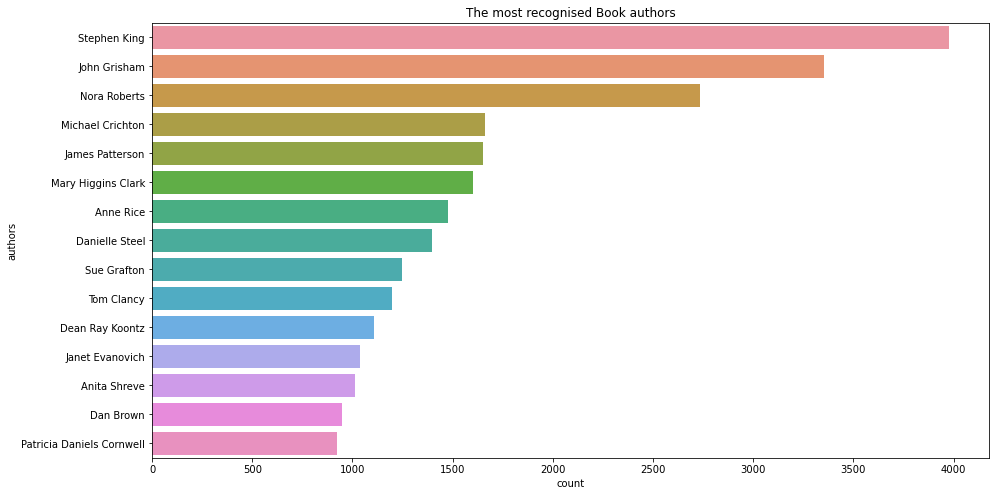

In [149]:
#plotting the most recognised book authors 
count_plot('authors', Final_Dataset, 'The most recognised Book authors')

>The most recognised book authors are Stephen King and John Grisham. On the other hand, Dan Brown and Patricia Dniels Cornwell are the least recognised book authors.

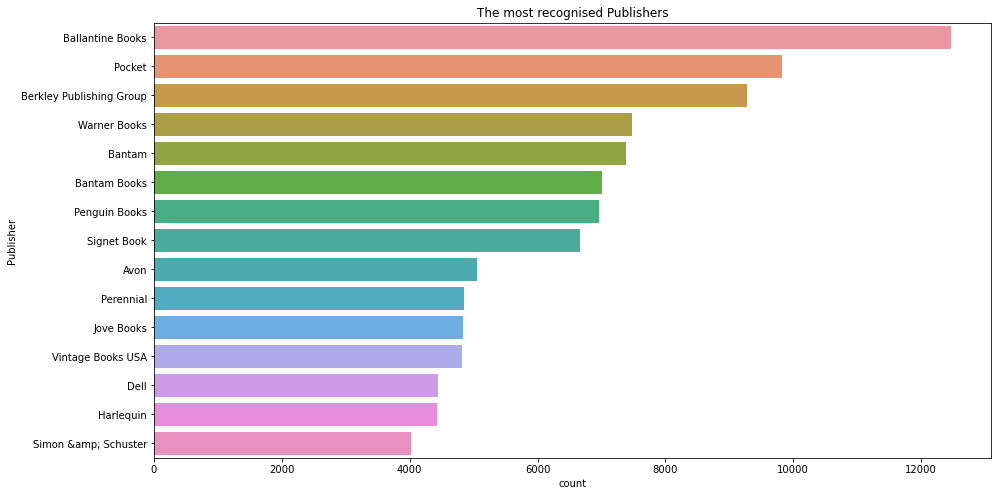

In [150]:
#plotting the most recognised publishers
count_plot('Publisher', Final_Dataset, 'The most recognised Publishers')

>The most recognised publisher is Ballantine Books and Pocket while the least recognised publisher is Harlequin and Simon &amp Schuster.

## 3.2 Bivariate Analysis

## 3.2.1 books_data

In [151]:
import seaborn as sns

### 3.2.1.1 categories and language

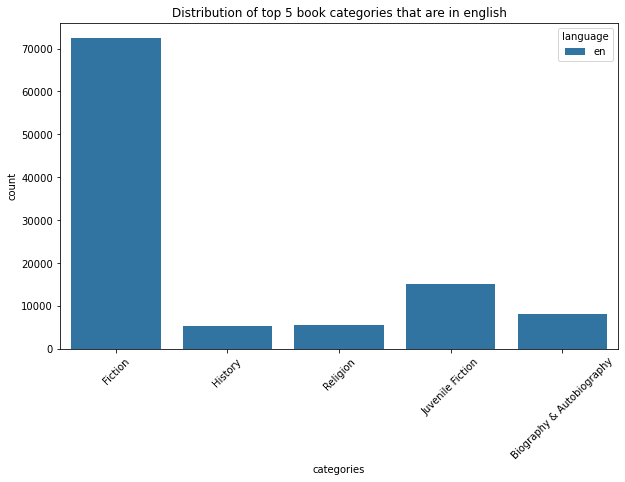

In [152]:
import matplotlib.pyplot as plt

# Select the top 5 categories
top_5_categories = books_data.groupby('categories')['categories'].count().sort_values(ascending=False).head(5)
# Filter the data to only include the top 5 categories
books_data_filtered = books_data[books_data['categories'].isin(top_5_categories.index) & (books_data['language'] == 'en')]


plt.figure(figsize=(10, 6))
sns.countplot(x='categories', hue='language', data=books_data_filtered)
plt.xticks(rotation=45)
plt.title("Distribution of top 5 book categories that are in english")
plt.show()


> the leading category that is in English is Fiction

### 3.2.1.2 maturity_rating and language

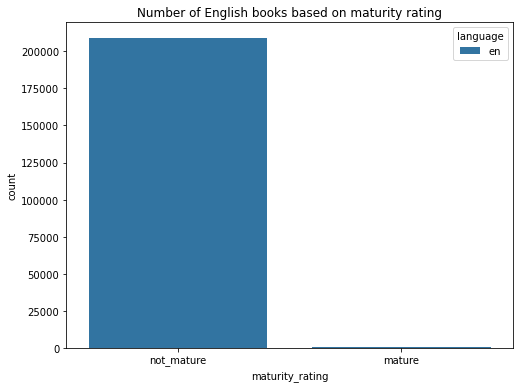

In [153]:
# create plot for 
# Filter the data to only include rows where the language is 'english'
books_data_filtered = books_data[books_data['language'] == 'en']

# Create the figure with dimensions 8 inches wide and 6 inches tall
plt.figure(figsize=(8, 6))

# Create the countplot
sns.countplot(x='maturity_rating', hue='language', data=books_data_filtered)
plt.title("Number of English books based on maturity rating")
plt.show()


> Most english books are not_mature

## 3.2.2 Final_Dataset

In [184]:
# function to plot bivariate analysis
def plot_bivariate(df, x, y):
    # Take the top 10 value counts for x and y
    x_top_10 = x.value_counts().head(10)
    y_top_10 = y.value_counts().head(10)

    # Create a bivariate bar plot
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=x_top_10.index, y=y_top_10.values, hue=y_top_10.index)
    plt.title("{} vs {}".format(x.name, y.name))
    plt.ylabel(y.name, fontsize=12)
    plt.xlabel(x.name, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.show()

#### 3.2.2.1 authors & Year-Of-Publication

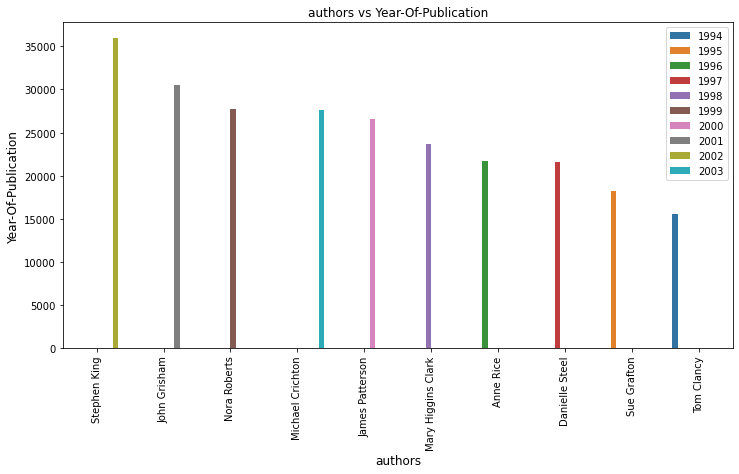

In [192]:
plot_bivariate(Final_Dataset, Final_Dataset['authors'], Final_Dataset['Year-Of-Publication'])


> Stephen King is the top most author of books published in 2002 and John Grisham in 2001.

#### 3.2.2.2 Publisher & Book-Rating

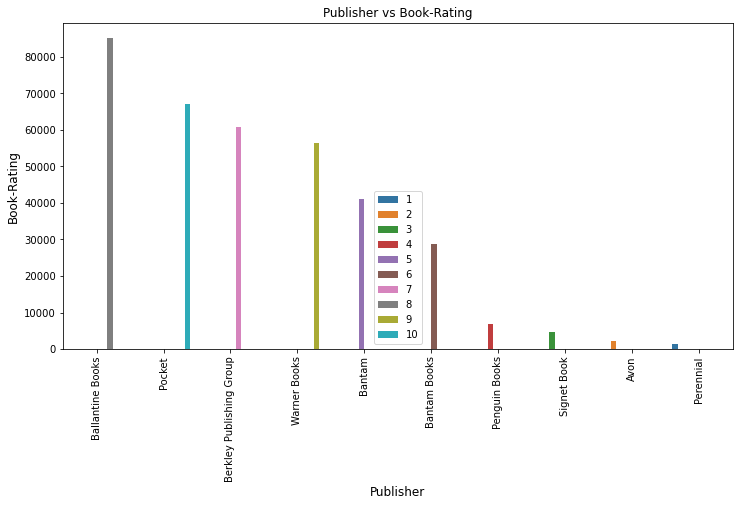

In [198]:
plot_bivariate(Final_Dataset, Final_Dataset['Publisher'], Final_Dataset['Book-Rating'])

> Most books published by Ballantine Books, have a rating of 8.

#### 3.2.2.3 language & categories

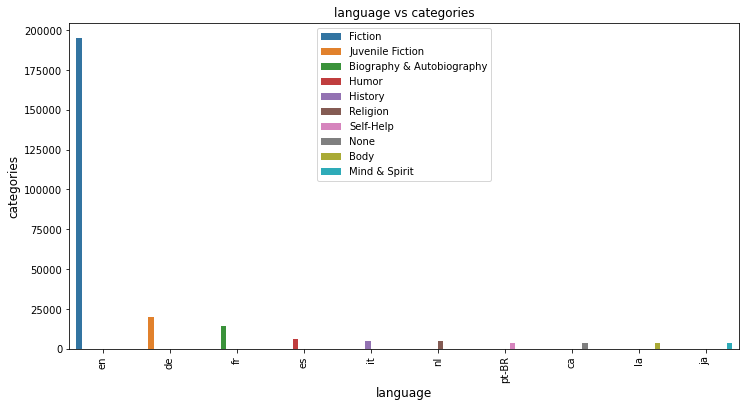

In [196]:
plot_bivariate(Final_Dataset, Final_Dataset['language'], Final_Dataset['categories'])

> English is the common language used in fiction books.

# 4. Modeling

## 4.1 Popularity-Based 

In [154]:
def popular(df, n=10):
    # Calculate the number of ratings and the average rating for each book
    popular_books = df.groupby("Book-Title").agg({
        "Book-Rating": ["count", "mean"]
    }).reset_index()
    popular_books.columns = ["Book-Title", "NumberOfVotes", "AverageRatings"]
    
    # Calculate the popularity score for each book using a weighted average of the rating and number of votes
    C = popular_books["AverageRatings"].mean()
    m = popular_books["NumberOfVotes"].quantile(0.90)
    popular_books["Popularity"] = (popular_books["NumberOfVotes"] * popular_books["AverageRatings"] + m * C) / (popular_books["NumberOfVotes"] + m)
    
    # Sort the books in descending order by popularity score
    popular_books = popular_books.sort_values(by="Popularity", ascending=False)
    
    # Return the top n most popular books
    return popular_books[["Book-Title", "Popularity"]].head(n)


# Recommend the top 10 most popular books
recommendations = popular(Final_Dataset, n=10)
print(recommendations)

                                                                Book-Title  \
31235                Harry Potter and the Chamber of Secrets Postcard Book   
71490  The Complete Monty Python's Flying Circus : All the Words, Volume 1   
58845                   Route 66 Postcards: Greetings from the Mother Road   
94598                              William Shakespeare: The Complete Works   
91138                                 Van Gogh Face to Face: The Portraits   
20387                                         Dilbert: A Book of Postcards   
12546                                                    Calvin and Hobbes   
19088                                       Death: The High Cost of Living   
81978               The Return of the King (The Lord of the Rings, Part 3)   
79653                                               The New Joy of Cooking   

       Popularity  
31235    9.396347  
71490    9.367472  
58845    9.267645  
94598    9.220413  
91138    9.194114  
20387    9.183898  
1

## 4.2 Item-Based

In [155]:
def item_based(bookTitle):
    
    # Changing Book Title input to string
    bookTitle=str(bookTitle)
    
    # Classifying books with fewer than 200 ratings as rare and with more than 200 as common
    if bookTitle in Final_Dataset["Book-Title"].values:
        rating_count=pd.DataFrame(Final_Dataset["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=200].index
        common_books=Final_Dataset[~Final_Dataset["Book-Title"].isin(rare_books)]
        
        #Reccomending top 3 most rated books if book title entered is rare
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print(*most_common, sep="\n")
       
        # Recommending top 5 books with highest correlation to the entered Book Title 
        else:
            common_books_pivot=common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
            title=common_books_pivot[bookTitle]
            recommendation_df=pd.DataFrame(common_books_pivot.corrwith(title).sort_values(ascending=False)).reset_index(drop=False)
            
            if bookTitle in [title for title in recommendation_df["Book-Title"]]:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==bookTitle].index[0])
                
            less_rating=[]
            for i in recommendation_df["Book-Title"]:
                if Final_Dataset[Final_Dataset["Book-Title"]==i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]
                
            recommendation_df=recommendation_df[0:5]
            recommendation_df.columns=["Book-Title","Correlation"]
            
            print("WOULD YOU LIKE to TRY THESE BOOKS?")
            for title, corr in zip(recommendation_df['Book-Title'], recommendation_df['Correlation']):
                print(title, corr)
                
    else:
        most_pop = popular(Final_Dataset, n=10)
        print(" COULD NOT FIND ")
        print("Consider our Most Popular Books")
        print(most_pop)

In [156]:
item_based("Me Talk Pretty One Day")

WOULD YOU LIKE to TRY THESE BOOKS?
Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1) 1.0
The Chamber 0.9999999999999999
She's Come Undone (Oprah's Book Club) 0.9999999999999999
The Poisonwood Bible: A Novel 0.9999999999999999
Timeline 0.944911182523068


In [157]:
item_based("Black House")

No Recommendations for this Book ☹️ 
 
YOU MAY TRY: 
 
The Summons
Good in Bed
The Red Tent (Bestselling Backlist)


In [158]:
item_based("Barbie")

❌ COULD NOT FIND ❌
Consider our Most Popular Books
                                                                Book-Title  \
31235                Harry Potter and the Chamber of Secrets Postcard Book   
71490  The Complete Monty Python's Flying Circus : All the Words, Volume 1   
58845                   Route 66 Postcards: Greetings from the Mother Road   
94598                              William Shakespeare: The Complete Works   
91138                                 Van Gogh Face to Face: The Portraits   
20387                                         Dilbert: A Book of Postcards   
12546                                                    Calvin and Hobbes   
19088                                       Death: The High Cost of Living   
81978               The Return of the King (The Lord of the Rings, Part 3)   
79653                                               The New Joy of Cooking   

       Popularity  
31235    9.396347  
71490    9.367472  
58845    9.267645  
94598    9

## 4.3 User Based

In [159]:
#Pivot Table of users who have voted >200 times (less computational demand)
users_above_200 = Final_Dataset['User-ID'].value_counts()[Final_Dataset['User-ID'].value_counts() > 200].index.tolist()
new_df = Final_Dataset[Final_Dataset['User-ID'].isin(users_above_200)]
users_pivot = new_df.pivot_table(index="User-ID", columns="Book-Title", values="Book-Rating")
users_pivot.fillna(0, inplace=True)

In [160]:
def users_choice(id):

    users_fav = new_df[new_df["User-ID"]==id].nlargest(5, 'Book-Rating')
    return users_fav

In [161]:
def user_based(new_df,id):
    if id not in new_df["User-ID"].values:
        print(" User NOT FOUND ")
    else:
        index=np.where(users_pivot.index==id)[0][0]
        similarity=cosine_similarity(users_pivot)
        similar_users=list(enumerate(similarity[index]))
        similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]
        user_rec=[]
        for i in similar_users:
            data=df[df["User-ID"]==users_pivot.index[i[0]]]
            user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))
    return user_rec

def user_based_optimized(new_df,id):
    if id not in new_df["User-ID"].values:
        print(" User NOT FOUND ")
    else:
        index=np.where(users_pivot.index==id)[0][0]
        similarity=cosine_similarity(users_pivot)
        similar_users=sorted(enumerate(similarity[index]),key = lambda x:x[1],reverse=True)[0:5] # sorted is used instead of list
        user_rec=[]
        for i in similar_users:
            data=Final_Dataset[Final_Dataset["User-ID"]==users_pivot.index[i[0]]]
            user_rec.extend(data.drop_duplicates("User-ID")["User-ID"].values) # list is removed
    return user_rec

In [162]:
def common(new_df, user, user_id):
    x=new_df[new_df["User-ID"]==user_id]
    user_books = x["Book-Title"].tolist()
    user_titles = set(user_books)
    
    recommend_books = []
    for i in user:
        y = new_df[(new_df["User-ID"]==i)]
        books = y[~y["Book-Title"].isin(user_titles)].sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(books["Book-Title"].tolist())
    
    return recommend_books[0:5]

In [ ]:
def users_choice(user_id):
    user_favorite = []
    user_id=random.choice(new_df["User-ID"].values)
    user_choice_df = new_df[new_df["User-ID"]==user_id]
    user_favorite = user_choice_df["Book-Title"].values
    return user_favorite
    
user_favorite=users_choice(user_id)
n=len(user_favorite)
print(" USER: {} ".format(user_id))